In [1]:
import pandas as pd
import xarray as xr
from fos import util
from fos.data import snotelmeta 
import datetime
import os
import numpy as np
from fos.util import get_wrf_data_points
from fos.data import snotel_no_ak


## reads data
def wrfread(datadir, gcm, exp, variant, domain, var):
    modeldir = datadir + gcm + '/postprocess/'+domain + '/'
    all_files = sorted(os.listdir(modeldir))
    read_files = []
    for ii in all_files:
        if (
            ii.startswith(var + ".")
            and model in ii
            and variant in ii
            and domain in ii
        ):
            if domain in ii:
                read_files.append(os.path.join(modeldir, str(ii)))
    assert len(read_files) > 0, f"No matching files found in {modeldir}"

    del all_files

    data = xr.open_mfdataset(read_files, combine="by_coords")
    var_read = data.variables[var]

    dates = []
    for val in data["day"].data:
        try:
            dates.append(datetime.datetime.strptime(str(val)[0:-2], "%Y%m%d").date())
        except ValueError:
            dates.append(datetime.datetime(int(str(val)[0:4]), int(str(val)[4:6]), 28))


    var_read = xr.DataArray(var_read, dims=["day", "lat2d", "lon2d"])
    var_read["day"] = dates
    return var_read

## load data based on parameteres that we want
var = 'snow'
modeldir = '/glade/campaign/uwyo/wyom0112/postprocess/'
model = 'ukesm1-0-ll'
variant = 'r2i1p1f2'
domain = 'd02'
basedir = '/glade/u/home/mcowherd/'
projectdir = basedir + 'fos-data/'
snoteldir = projectdir + 'snoteldata/'
wrfdir = '/glade/campaign/uwyo/wyom0112/postprocess/'
wrfcoorddir = projectdir 

## LOAD DATA ## 
mod_historical = model +'_'+ variant + '_historical_bc'
mod_future = model +'_' + variant+ '_ssp370_bc'
gcm = mod_historical
date_start_pd, date_end_pd = [1980, 1, 1], [2013, 12, 31]  # 30 years, historical
exp = "hist"
var_wrf = wrfread(modeldir, gcm, exp, variant, domain, var)
var_wrf = util.screen_times_wrf(var_wrf, date_start_pd, date_end_pd)

# LOAD DATA future dates
date_start_pd, date_end_pd = [2014, 1, 1], [2100, 12, 31]
gcm = mod_future
model = "ssp370"
var_wrf_ssp370 = wrfread(modeldir, gcm, model, variant, domain, var)
var_wrf_ssp370 = util.screen_times_wrf(var_wrf_ssp370, date_start_pd, date_end_pd)
wrfdata = [var_wrf, var_wrf_ssp370]


In [2]:
## make one big xarray ds with the variable
snow = xr.concat([var_wrf, var_wrf_ssp370], dim = 'day')
snow = snow.to_dataset(name = 'snow')

In [31]:
## for a single basin:
masks = xr.open_dataset('../data/basin_masks.nc')
mask_gunn = masks['basin_masks'][0]

In [37]:
## need to change this to groupby water year
maxyear = snow.groupby(snow.day.dt.year).max().where(mask_gunn)

KeyboardInterrupt: 

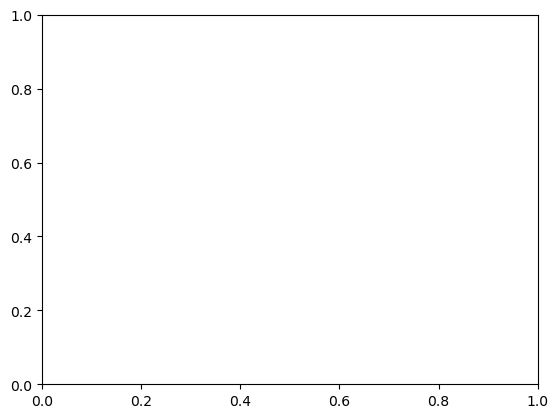

In [42]:
## check that the masking worked
import matplotlib.pyplot as plt
plt.pcolormesh(maxyear['snow'][0])

In [45]:
## OLD VERSION
import glob
import xarray as xr
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

files = glob.glob('/glade/u/home/mcowherd/nh-WRF/time_series/*') ## pre-made files with snotel stations and basin-wide average peak SWE, fro mbefore
data = xr.open_dataset(files[0]).to_dataframe()
pvars = list(data.columns)[0:-1]
output_var = 'maxval_basin' # Basin-wide snow water equivalent

## uses the first 86 years as training, then predicts the rest. would do this in a slightly different way for the n-1 format.
train_data = data[0:86]
test_data = data[86:]
y_train = np.array(train_data[output_var])
y_test = np.array(test_data[output_var])

X_train = train_data[pvars].values.reshape((-1, len(pvars)))
X_test = test_data[pvars].values.reshape((-1, len(pvars)))
reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)
basin = files[0].split('/')[-1].split('.')[0]
outputs = ({'basin': basin, 'model':'linreg_86', 'MSE': mean_squared_error(y_test, y_pred), 'R2':r2_score(y_test, y_pred), 'ytest': y_test, 'ypred':y_pred})
outputs


{'basin': 'Powder',
 'model': 'linreg_86',
 'MSE': 0.24231644137370587,
 'R2': 0.11193809038368874,
 'ytest': array([0.6530202 , 1.011659  , 0.79945916, 0.5415832 , 0.73667663,
        1.4585127 , 0.76249003, 1.449996  , 0.7457103 , 0.56349224,
        1.1674377 , 0.96945876, 3.0615075 , 0.98176   , 0.77431935,
        0.5429413 , 0.7134076 , 0.5746162 , 1.3671218 , 0.8791103 ,
        0.5872054 , 0.3046924 , 0.4421071 , 1.2631923 , 0.74674207,
        0.6335426 , 1.0624342 , 0.63923955, 0.3218614 , 0.7463375 ,
        1.8258287 ]),
 'ypred': array([0.75346495, 0.91786574, 0.84063875, 1.01431579, 1.02290049,
        0.88085993, 1.1508626 , 1.10636857, 0.82195652, 0.91068072,
        0.76286304, 0.7505259 , 1.05726376, 0.81705876, 0.82229121,
        0.57087475, 0.63451016, 0.87204086, 0.98009773, 1.14522067,
        0.82923957, 0.66335336, 0.66762829, 0.69774451, 0.93895648,
        0.81234081, 0.71747949, 0.65496396, 0.8923853 , 0.72650461,
        0.92531766])}

In [51]:
from pathlib import Path
from sklearn.linear_model import LinearRegression

## this is the idea behind the n-1, but the current data setup is for the csv. 
for max_year in range(2020, 2097):
# max_year = 2020
    df_train = df[df.wyear <= max_year]
    df_group = df_train.groupby("pt")
    # df_group_test = df[df.wyear > max_year].groupby("pt")] 
    # linear regression for each group

    res = df_group.apply(lambda x: LinearRegression().fit(x[['maxval_pt']].values, x[['maxval_basin']].values))
    res.name = 'lr'
    lr_df = pd.merge(df, res, how='left', left_on='pt', right_on='pt')
    df_test = lr_df[lr_df.wyear == max_year+1]
    df_test['lr_res'] = df_test.apply(lambda x: max([0,x['lr'].predict([[x['maxval_pt']]])[0][0]]), axis=1)
    df_test['lr_res_diff'] = df_test['lr_res'] - df_test['maxval_basin']

    all_res.append(df_test)

AttributeError: 'DataFrame' object has no attribute 'wyear'

,maxval_pt_1,maxval_pt_2,maxval_pt_3,maxval_pt_4,maxval_pt_5,maxval_basin
date,,,,,,
2000-01-01,5.062289,6.513053,4.707819,9.838503,3.216907,0.577808
2000-01-02,5.410796,9.967355,4.970025,25.304174,7.783249,1.669941
2000-01-03,3.965666,7.769357,3.686273,13.862869,3.307747,0.851363
2000-01-04,6.151101,6.244598,4.328708,13.654012,3.943367,1.800577
2000-01-05,4.891934,8.062729,4.982734,15.285724,3.828772,0.618429
...,...,...,...,...,...,...
2000-04-22,4.113493,3.128671,5.957768,5.634676,1.494098,1.062434
2000-04-23,0.884649,2.366300,1.148001,6.559222,1.086044,0.639240
2000-04-24,1.611926,5.554607,1.532239,7.256350,4.141365,0.321861


In [ ]:
vals = []
import numpy as np
for entry in all_res:
    vals.append(np.nanmean(entry['lr_res_diff'] / entry['maxval_basin']))
fig,ax = plt.subplots()
ax.plot(range(2021,2098),vals)
ax.set_ylabel('percent error')
plt.show()